In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10, 6)


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Load election results
results = pd.read_csv("/content/sample_data/DFWResult(1).csv")

# Load precinct geometry
precincts = gpd.read_file("/content/sample_data/GDF.geojson")

results.head(), precincts.head()


(   precinct                                     office party_detailed  \
 0     15795                  COURT OF CRIMINAL APPEALS       DEMOCRAT   
 1       860                  COURT OF CRIMINAL APPEALS     REPUBLICAN   
 2     76820                  COURT OF CRIMINAL APPEALS       DEMOCRAT   
 3     54886                  COURT OF CRIMINAL APPEALS     REPUBLICAN   
 4      6265  COURT OF CRIMINAL APPEALS PRESIDING JUDGE     REPUBLICAN   
 
   party_simplified   mode  votes county_name  county_fips jurisdiction_name  \
 0         DEMOCRAT  TOTAL   9612      COLLIN        37306            COLLIN   
 1       REPUBLICAN  TOTAL   4723      COLLIN        53860            COLLIN   
 2         DEMOCRAT  TOTAL   3707      COLLIN        90872            COLLIN   
 3       REPUBLICAN  TOTAL   4542      COLLIN        14062            COLLIN   
 4       REPUBLICAN  TOTAL   1650      COLLIN        88037            COLLIN   
 
    jurisdiction_fips  ...  state special writein  state_po state_fips  

In [6]:
assert "pctkey" in results.columns
assert "pctkey" in precincts.columns


In [7]:
# Standardize column names
results.columns = results.columns.str.lower()
precincts.columns = precincts.columns.str.lower()

# Drop rows with missing pctkey
results = results.dropna(subset=["pctkey"])
precincts = precincts.dropna(subset=["pctkey"])


In [8]:
results["votes"] = pd.to_numeric(results["votes"], errors="coerce").fillna(0)


In [9]:
# Ensure GeoDataFrame has CRS
if precincts.crs is None:
    precincts = precincts.set_crs(epsg=4326)

# Project to meters for area calculations
precincts_proj = precincts.to_crs(epsg=3857)


In [10]:
precincts_proj["area_sqm"] = precincts_proj.geometry.area
precincts_proj["centroid"] = precincts_proj.geometry.centroid

precincts_proj[["pctkey", "area_sqm"]].head()


,pctkey,area_sqm
0,850001,4.187881e+06
1,850002,9.367323e+06
2,850003,1.468914e+07
3,850004,8.759124e+07
4,850005,6.570366e+06


In [14]:
print(precincts_proj["pctkey"].dtype)
print(results["pctkey"].dtype)


object
int64


In [17]:
precincts_proj["pctkey"] = precincts_proj["pctkey"].astype(str)
results["pctkey"] = results["pctkey"].astype(str)

print(precincts_proj["pctkey"].dtype)
print(results["pctkey"].dtype)


object
object


In [18]:
merged = precincts_proj.merge(results, on="pctkey", how="inner")
merged.head()


,pctkey,county,city,us_congress,state_senate,state_house,state_board_of_education,commissoner_district,jp_district,city_whole,...,stage,state,special,writein,state_po,state_fips,state_cen,state_ic,date,magnitude
0,850001,Collin,Mckinney,33049,6525,63866,1018,Collin - 3,Collin - 1,MC,...,GEN,TEXAS,False,False,TX,85966,7105,66114,2024-11-05,3
1,850001,Collin,Mckinney,33049,6525,63866,1018,Collin - 3,Collin - 1,MC,...,GEN,TEXAS,False,False,TX,4342,72862,74045,2024-11-05,10
2,850001,Collin,Mckinney,33049,6525,63866,1018,Collin - 3,Collin - 1,MC,...,GEN,TEXAS,False,False,TX,38405,53243,58435,2024-11-05,50
3,850001,Collin,Mckinney,33049,6525,63866,1018,Collin - 3,Collin - 1,MC,...,GEN,TEXAS,False,False,TX,55137,63341,78110,2024-11-05,62
4,850001,Collin,Mckinney,33049,6525,63866,1018,Collin - 3,Collin - 1,MC,...,GEN,TEXAS,False,False,TX,64964,36834,52815,2024-11-05,77


In [20]:
print("Precincts:", len(precincts_proj))
print("Results:", len(results))
print("Merged:", len(merged))


Precincts: 100
Results: 95380
Merged: 5482


In [22]:
merged.columns


Index(['pctkey', 'county', 'city', 'us_congress', 'state_senate',
       'state_house', 'state_board_of_education', 'commissoner_district',
       'jp_district', 'city_whole', 'isd_whole', 'city_sng', 'isd_sng',
       'geometry', 'area_sqm', 'centroid', 'precinct', 'office',
       'party_detailed', 'party_simplified', 'mode', 'votes', 'county_name',
       'county_fips', 'jurisdiction_name', 'jurisdiction_fips', 'candidate',
       'district', 'dataverse', 'year', 'stage', 'state', 'special', 'writein',
       'state_po', 'state_fips', 'state_cen', 'state_ic', 'date', 'magnitude'],
      dtype='object')

In [23]:
merged = merged.rename(columns={
    "party_simplified": "party"
})


In [24]:
votes_by_county_party = (
    merged.groupby(["county", "party"], as_index=False)["votes"]
    .sum()
)

votes_by_county_party.head()


,county,party,votes
0,Collin,DEMOCRAT,10954213
1,Collin,LIBERTARIAN,2057535
2,Collin,OTHER,3609046
3,Collin,REPUBLICAN,10937490


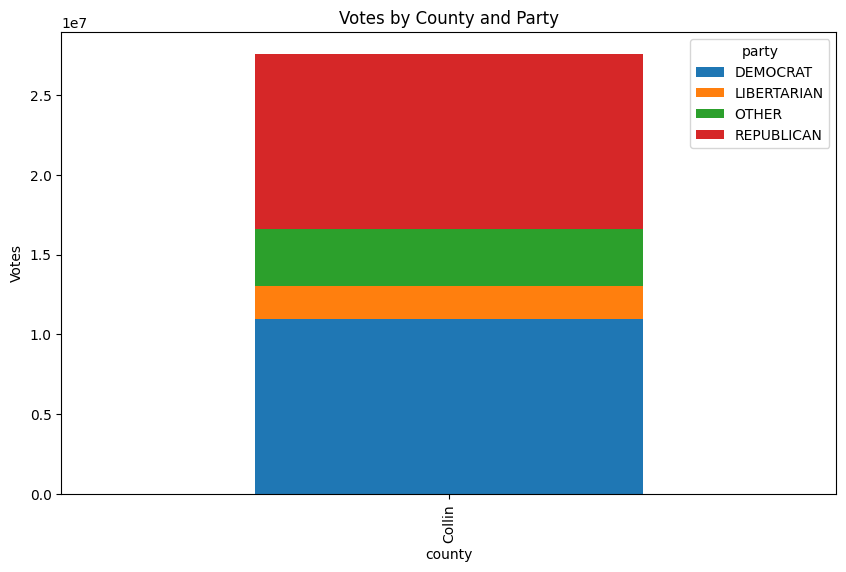

In [25]:
votes_by_county_party.pivot(
    index="county",
    columns="party",
    values="votes"
).plot(kind="bar", stacked=True)

plt.title("Votes by County and Party")
plt.ylabel("Votes")
plt.show()


In [26]:
merged["area_sqkm"] = merged["area_sqm"] / 1e6
merged["vote_density"] = merged["votes"] / merged["area_sqkm"]


In [27]:
merged[["votes", "area_sqkm", "vote_density"]].describe()


,votes,area_sqkm,vote_density
count,5482.000000,5482.000000,5482.000000
mean,5027.049252,15.433102,10734.923066
std,2916.109229,31.250711,61872.600382
min,2.000000,0.011260,0.019843
25%,2476.000000,2.579075,239.106384
50%,5095.500000,3.975025,947.007277
75%,7540.000000,10.364382,2175.328844
max,9996.000000,222.147357,875219.083063


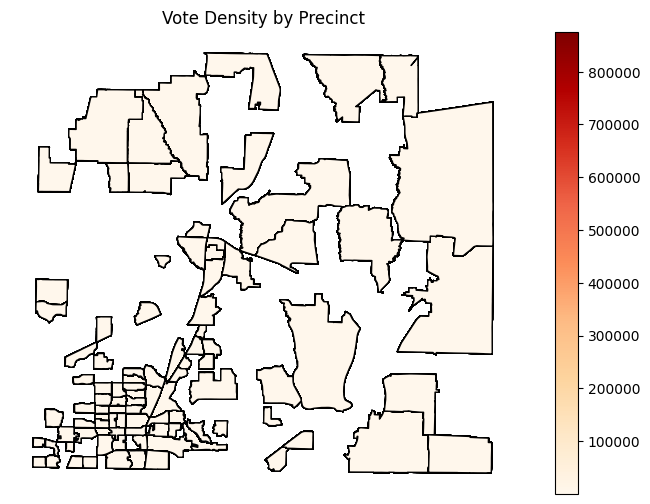

In [28]:
merged.plot(
    column="vote_density",
    cmap="OrRd",
    legend=True,
    edgecolor="black"
)
plt.title("Vote Density by Precinct")
plt.axis("off")
plt.show()


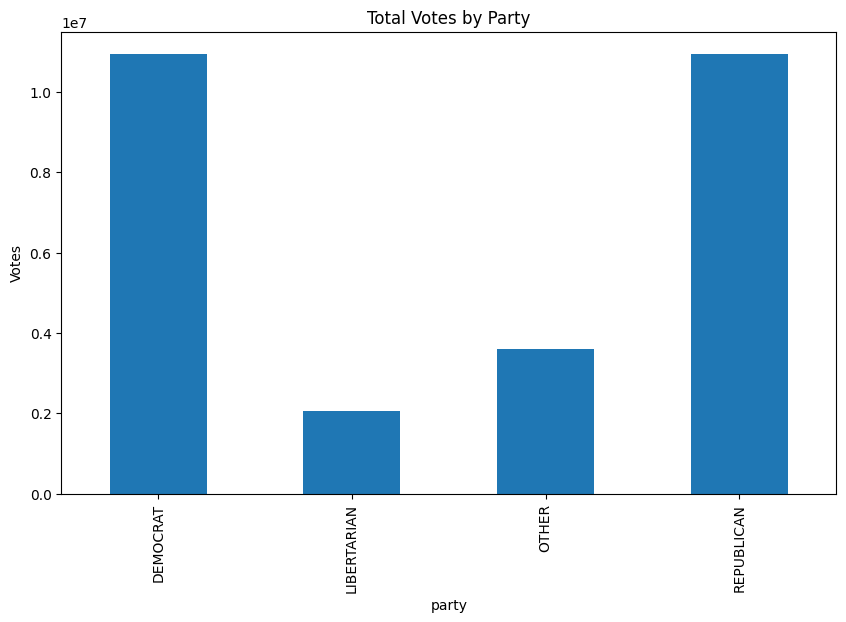

In [29]:
merged.groupby("party")["votes"].sum().plot(kind="bar")
plt.title("Total Votes by Party")
plt.ylabel("Votes")
plt.show()


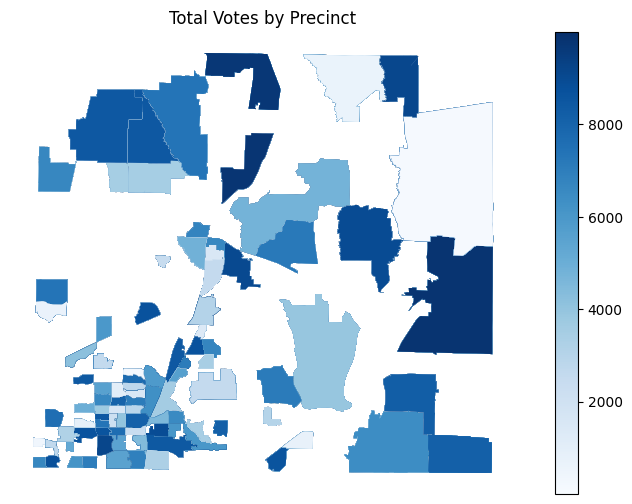

In [30]:
merged.plot(
    column="votes",
    cmap="Blues",
    legend=True
)
plt.title("Total Votes by Precinct")
plt.axis("off")
plt.show()


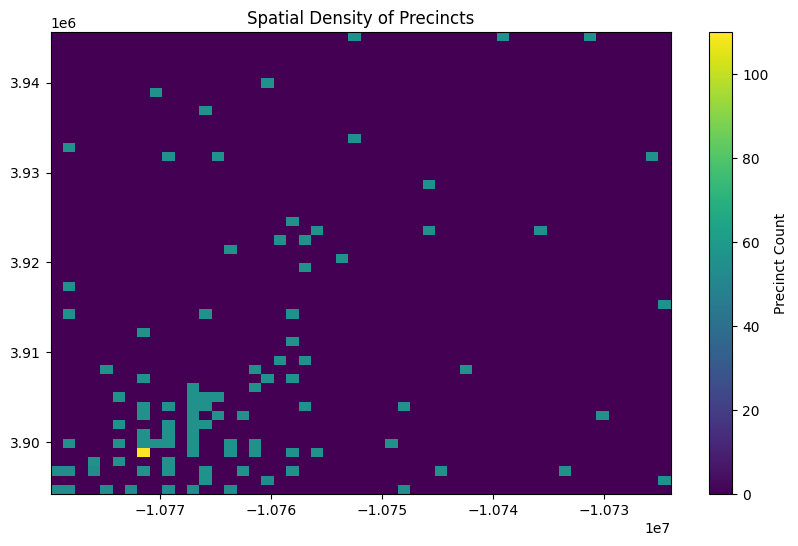

In [31]:
x = merged.geometry.centroid.x
y = merged.geometry.centroid.y

plt.hist2d(x, y, bins=50)
plt.colorbar(label="Precinct Count")
plt.title("Spatial Density of Precincts")
plt.show()


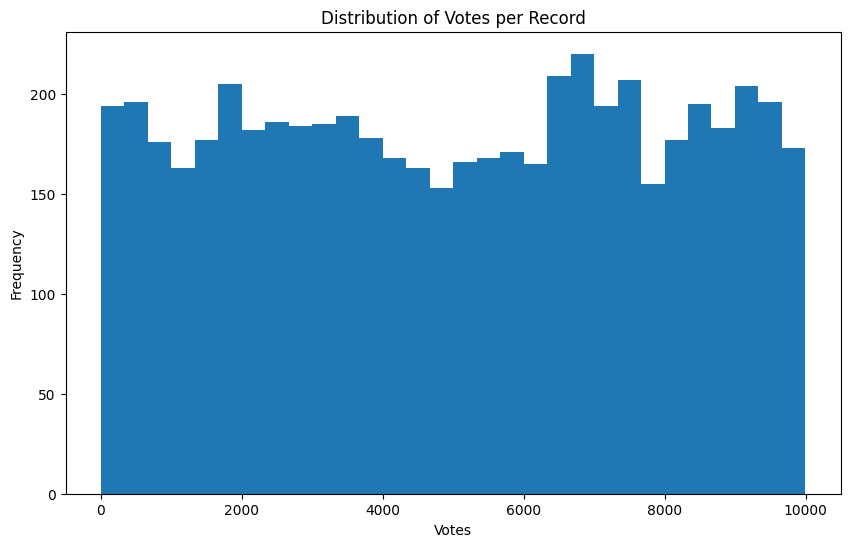

In [33]:
merged["votes"].plot(kind="hist", bins=30)
plt.title("Distribution of Votes per Record")
plt.xlabel("Votes")
plt.show()
